Loading data

In [ ]:
import os.path as op
import mne
from scripts.processing.library.config import study_path, subjects_dir, N_JOBS, spacing
%matplotlib inline


In [2]:
# The paths to Freesurfer reconstructions
subject = "sub001" 
subjects_dir = op.join(study_path, 'subjects')
subjects_dir

'/Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects'

# Compute and visualize BEM surfaces

Using surface: /Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub001/bem/inner_skull.surf
Using surface: /Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub001/bem/outer_skull.surf
Using surface: /Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub001/bem/outer_skin.surf


/Users/ricklicona/PycharmProjects/RExam/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


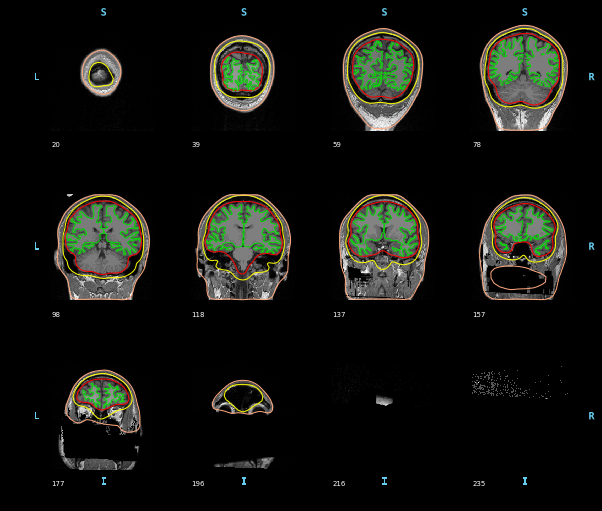

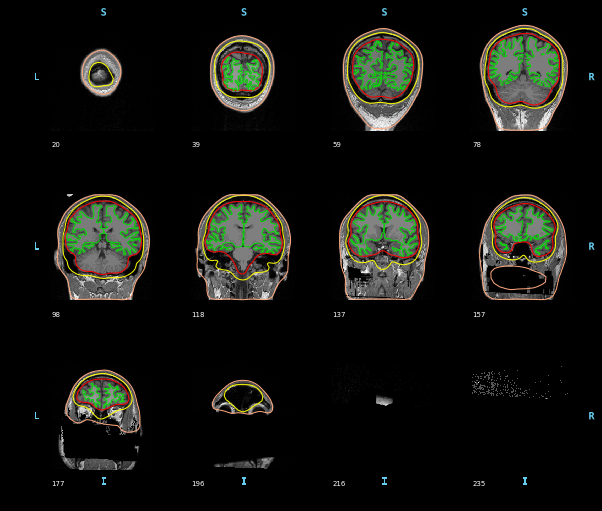

In [3]:
mne.viz.plot_bem(subject=subject, subjects_dir=subjects_dir,
                 brain_surfaces='white', orientation='coronal')

## Visualizing the coregistration¶

In [10]:
# the raw file containing the channel location + types
raw_fname = "/Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/ds117/sub001/MEG/run_01_raw.fif"
info = mne.io.read_info(raw_fname)

    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle


**Note: It is important to consider that we have 6 runs. In this case we are taking the RUN 1.**

In [12]:
#Mayavi
from mayavi import mlab 
mlab.options.offscreen = True
mlab.init_notebook() 
trans = "/Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/ds117/sub001/MEG/sub001-trans.fif"

# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.

corr = mne.viz.plot_alignment(info, trans, subject=subject, dig=True,
                       meg=['helmet', 'sensors'], subjects_dir=subjects_dir,
                       surfaces='head-dense')
corr

Notebook initialized with ipy backend.


OSError: No head surface found for subject sub001 after trying:
/Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub001/bem/sub001-head-dense.fif
/Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub001/surf/lh.seghead

## Compute Source Space

In [4]:
src = mne.setup_source_space(subject, spacing='oct6', add_dist='patch',
                             subjects_dir=subjects_dir)
print(src)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects
Subject      = sub001
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub001/surf/lh.white...
Mapping lh sub001 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub001/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/140356 selected to source space (oct = 6)

Loading /Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub001/surf/rh.white...
Mapping rh sub001 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geome

Using surface: /Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub001/bem/inner_skull.surf
Using surface: /Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub001/bem/outer_skull.surf
Using surface: /Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub001/bem/outer_skin.surf


/Users/ricklicona/PycharmProjects/RExam/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


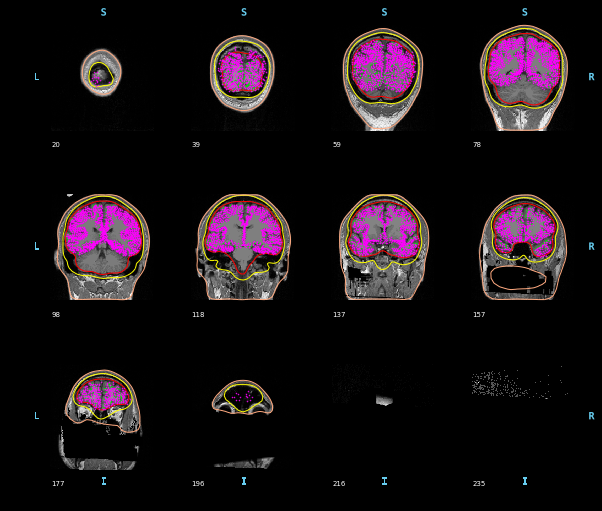

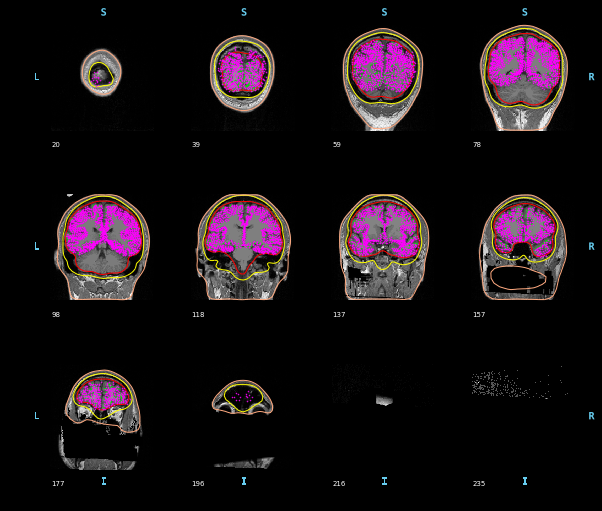

In [5]:
mne.viz.plot_bem(subject=subject, subjects_dir=subjects_dir,
                 brain_surfaces='white', src=src, orientation='coronal')

## Compute forward solution

In [8]:
conductivity = (0.3,)  # for single layer
#conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject=subject, ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model) 

Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
inner skull CM is  -1.04 -19.17  26.22 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


In [13]:
fwd = mne.make_forward_solution(raw_fname, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=1,
                                verbose=True)
print(fwd)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=140356, n_used=4098>, <surface (rh), n_vertices=140464, n_used=4098>] MRI (surface RAS) coords, subject 'sub001', ~26.8 MB>
MRI -> head transform : /Volumes/HD710A/MNE+PAPER/mne-biomag-group-demo/ds117/sub001/MEG/sub001-trans.fif
Measurement data      : run_01_raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999250  0.018204 -0.034164       5.84 mm
    -0.001895  0.904475  0.426522      16.56 mm
     0.038664 -0.426137  0.903832      24.30 mm
     0.000000  0.000000  0.000000       1.00

Read 306 MEG channels from info
99 coil definitions read
Coordinate transformation: MEG device -> head
     0.999669 -0.024376  0.008270       2.90 mm
     0.023726  0.997177  0.071248     -12.99 mm
    -0.009983 -0.071028 

In [14]:
print(f'Before: {src}')
print(f'After:  {fwd["src"]}')

Before: <SourceSpaces: [<surface (lh), n_vertices=140356, n_used=4098>, <surface (rh), n_vertices=140464, n_used=4098>] MRI (surface RAS) coords, subject 'sub001', ~26.8 MB>
After:  <SourceSpaces: [<surface (lh), n_vertices=140356, n_used=3675>, <surface (rh), n_vertices=140464, n_used=3698>] head coords, subject 'sub001', ~26.8 MB>


In [15]:
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 306 sensors x 22119 dipoles


In [16]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Leadfield size : 306 sensors x 7373 dipoles


In [17]:
leadfield

array([[-6.1948067e-06, -6.9661578e-06, -3.7067239e-06, ...,
        -9.3047529e-06, -3.8313146e-06, -1.9419674e-06],
       [-2.6367397e-06, -3.3815013e-06,  6.8267573e-06, ...,
         8.3350119e-07, -2.8342751e-07, -6.4898563e-06],
       [-3.9079305e-07, -5.1253494e-07,  4.2532264e-07, ...,
         1.2246836e-06, -6.1853910e-07,  2.8506466e-07],
       ...,
       [-8.4434478e-06, -1.5093698e-05,  2.1821859e-05, ...,
         2.8118009e-05,  9.2922797e-05,  1.2568121e-04],
       [ 2.7593263e-05,  2.7056200e-05, -6.0185511e-07, ...,
        -1.3761256e-05, -5.2000170e-05, -2.8352806e-06],
       [-1.7873654e-06, -2.0025598e-06, -2.6474359e-07, ...,
         6.7362045e-08, -6.6992448e-06, -5.2258342e-06]], dtype=float32)